In [1]:
# Import necessary packages
using JuMP
using Gurobi
using CSV
using DataFrames
using Plots

In [2]:
# Load data from CSV files
energy_df = CSV.read("HW2_data/energy.csv", DataFrame)
capacity_df = CSV.read("HW2_data/capacity.csv", DataFrame)
utilization_df = CSV.read("HW2_data/utilization.csv", DataFrame)
maxutil_df = CSV.read("HW2_data/maxutil.csv", DataFrame)

# Get matrix of energy consumption and capacities
energy_consumptions = Matrix(energy_df)[:, 2:21] # 1000 x 20 matrix of energy consumption (get rid of index header to prevent error below)
machine_capacity = capacity_df.capacity # Capacity of each machine j (vector of size 20)
resources_needed_for_job = Matrix(utilization_df)[:, 2:21] # 1000 x 20 matrix of utilization rij
max_utilization = maxutil_df.maxutil # Maximum utilization of each machine j

println("loaded :)")

loaded :)


Optimal Utilization when all jobs are considered equal:

In [9]:
# Define problem dimensions
num_jobs = size(energy_consumptions, 1) # 1000 jobs
num_machines = size(energy_consumptions, 2) # 20 machines
println(num_jobs)
println(num_machines)

# Model formulation
model = Model(Gurobi.Optimizer)

# Decision variables: x[i,j] = 1 if job i is assigned to machine j, otherwise 0
@variable(model, x[1:num_jobs, 1:num_machines], Bin)

# Objective: Minimize total energy consumption
@objective(model, Min, sum(energy_consumptions[i, j] * x[i, j] for i in 1:num_jobs, j in 1:num_machines))

# Constraints: Each job must be assigned to exactly one machine
@constraint(model, [i in 1:num_jobs], sum(x[i, j] for j in 1:num_machines) == 1)

# Machine capacity constraints: Total number of jobs on each machine cannot exceed its capacity
# toggle this to answer part ii
@constraint(model, [j in 1:num_machines], sum(x[i, j] for i in 1:num_jobs) <= machine_capacity[j])

# Solve the model
optimize!(model)

# Results
println("Optimal energy consumption: ", objective_value(model))

jobs_per_machine = [sum(value(x[i, j]) for i in 1:num_jobs) for j in 1:num_machines]

energy_consumption_per_machine = [sum(value(x[i, j]) * energy_consumptions[i, j] for i in 1:num_jobs) for j in 1:num_machines]
min_energy_machine, min_indx = findmin(energy_consumption_per_machine)
jobs_not_assigned_to_min_energy_machine = num_jobs - jobs_per_machine[min_indx]

# Find number of machines with sub-maximal number of jobs
best_machine = [argmin(energy_consumptions[i,:]) for i in 1:num_jobs] # best machine j for job i by energy consuption
sub_opt_num = sum(value(x[i, best_machine[i]]) == 1 ? 0 : 1 for i in 1:num_jobs) # sub of jobs that weren't assigned to their corresponding best machien


# Print results
println("Number of jobs per machine: ", jobs_per_machine)
println("Number of jobs not assigned to the machine with lowest energy consumption: ", jobs_not_assigned_to_min_energy_machine)
println("Numer of jobs not assinged as to maximize capacity of machine: ", sub_opt_num)

1000
20
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.0.0 24A348)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1020 rows, 20000 columns and 40000 nonzeros
Model fingerprint: 0x20760193
Variable types: 0 continuous, 20000 integer (20000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 49453.678476
Presolve time: 0.02s
Presolved: 1020 rows, 20000 columns, 40000 nonzeros
Variable types: 0 continuous, 20000 integer (20000 binary)

Root relaxation: objective 4.141651e+04, 1369 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

Optimal Utilization when jobs have varying demands:

In [4]:
# Define problem dimensions
num_jobs = size(energy_consumptions, 1) # 1000 jobs
num_machines = size(energy_consumptions, 2) # 20 machines
println(num_jobs)
println(num_machines)

# Model formulation
model = Model(Gurobi.Optimizer)

# x[i,j] must be non negative
@variable(model, x[1:num_jobs, 1:num_machines] >= 0)

# Objective: Minimize total energy consumption
@objective(model, Min, sum(energy_consumptions[i, j] * x[i, j] for i in 1:num_jobs, j in 1:num_machines))

# Constraints: Each job must be fully assigned to some n machiness
@constraint(model, limit[i in 1:num_jobs], sum(x[i, j] for j in 1:num_machines) == 1)

# Machine utilization constraints: Total utilization of all jobs on each machine cannot exceed machine's max utilization
@constraint(model, util[j in 1:num_machines], sum(resources_needed_for_job[i,j] * x[i,j] for i in 1:num_jobs) <= max_utilization[j])

println("solving!")
# Solve the model
optimize!(model)

# Results
println("Optimal energy consumption: ", objective_value(model))

# Number of jobs assigned to each machine
jobs_per_machine = [sum(value(x[i, j]) for i in 1:num_jobs) for j in 1:num_machines]

# Number of jobs not fully assigned (if any)
unassigned_jobs = num_jobs - sum(jobs_per_machine)

# Find number of machines with sub-maximal number of jobs
best_machine = [argmin(energy_consumptions[i,:]) for i in 1:num_jobs] # best machine j for job i by energy consuption
sub_opt_num = sum(value(x[i, best_machine[i]]) == 1 ? 0 : 1 for i in 1:num_jobs) # sub of jobs that weren't assigned to their corresponding best machine

# Print results
println("Number of jobs per machine: ", jobs_per_machine)
println("Number of unassigned jobs: ", unassigned_jobs)
println("Numer of jobs not assinged as to maximize capacity of machine: ", sub_opt_num)

1000
20
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
solving!
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.0.0 24A348)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1020 rows, 20000 columns and 40000 nonzeros
Model fingerprint: 0xa2b521b4
Coefficient statistics:
  Matrix range     [1e+00, 9e+02]
  Objective range  [7e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Presolve time: 0.01s
Presolved: 1020 rows, 20000 columns, 40000 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+04
 Factor NZ  : 2.168e+04 (roughly 9 MB of memory)
 Factor Ops : 4.729e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual  

plot code

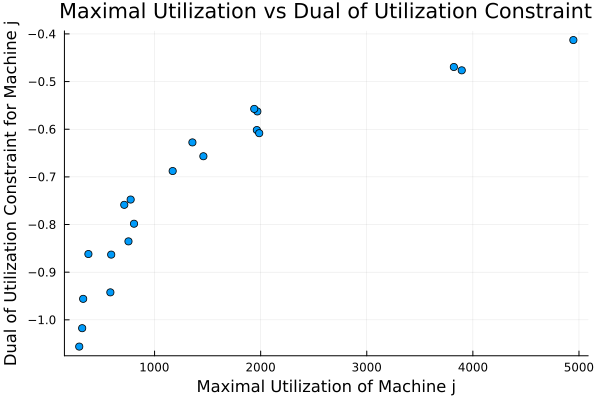

In [8]:
# Part e: Scatter plot of maximal utilization of each machine

dual_variables = [dual(util[j]) for j in 1:num_machines]

# Scatter plot: Maximal utilization (U_max) vs. Dual variables (shadow prices)
scatter(max_utilization, dual_variables, xlabel="Maximal Utilization of Machine j", ylabel="Dual of Utilization Constraint for Machine j", title="Maximal Utilization vs Dual of Utilization Constraint", legend=false)
#savefig("dual_vs_utilization.png")